# Long Short-Term Tennis Prediction

Sports outcome prediction is a difficult field in forecasting as there is always a lot of uncertainty involved. This is caused by the fact that gathering crucial predictive information is often inaccessible (e.g. think about the daily physical and mental state of a player or injuries happening in a game). In team sports additional uncertainty comes into play via intercorrelation of players' performances. To circumvent the latter, we decided to focus on tennis, and found that historical data of matches are fairly predictive for future outcomes. Our prediction model is two-fold and consists of a tree-based machine learning algorithm that captures long-term dependencies and a bayesian model that incorporates short-term performance of a player.

## Data

Our dataset contains data about all ATP singles matches in men's tennis, played since 1968. Most of the included features we use are available for games since 1991. Each row represents one match and the dataframe can be subdivided into three parts: information about the winner, information about the loser and general information about the game. The players' data consists of classical tennis statistics such as the percentage of first services that were won, number of aces and double faults, number of breakpoints that were faced and saved, and so on. General information includes duration of the match, the end score and the surface on which the match took place, as well as name and date of the tourney.

(The data can be downloaded here: https://www.kaggle.com/sijovm/atpdata)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data = pd.read_csv('ATP.csv')
data.columns

Index(['best_of', 'draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'loser_age', 'loser_entry', 'loser_hand', 'loser_ht', 'loser_id', 'loser_ioc', 'loser_name', 'loser_rank', 'loser_rank_points', 'loser_seed', 'match_num', 'minutes', 'round', 'score', 'surface', 'tourney_date', 'tourney_id', 'tourney_level', 'tourney_name', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt', 'winner_age', 'winner_entry', 'winner_hand', 'winner_ht', 'winner_id', 'winner_ioc', 'winner_name', 'winner_rank', 'winner_rank_points', 'winner_seed'], dtype='object')

## Data Preprocessing

As explained above, the data is sorted by winner and loser attributes. The first thing we do is to define the winner name as our target variable for learning and afterwards we randomly permute the positions of the set of all loser attributes and the set of all winner attributes, in order to get rid of the bias that the target is always equal to the first player. 

In [60]:
data['target'] = data['winner_name']

def shuffle_winner_loser(x):
    arr = [x[['l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt',
              'loser_age', 'loser_entry', 'loser_hand','loser_ht', 'loser_name', 'loser_rank', 'loser_rank_points']],
           x[['w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt', 
              'winner_age', 'winner_entry', 'winner_hand','winner_ht', 'winner_name', 'winner_rank',
              'winner_rank_points']]]
    
    indexchoice = np.random.choice([0,1],1,p=[.5,.5])[0]
    
    for i in [0,1]:
        if i != indexchoice:
            x[['w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt',
               'winner_age', 'winner_entry', 'winner_hand','winner_ht', 'winner_name', 'winner_rank', 
               'winner_rank_points']] = arr[i]
            
    x[['l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt',
       'loser_age', 'loser_entry', 'loser_hand','loser_ht', 'loser_name', 'loser_rank', 'loser_rank_points']] = arr[indexchoice]
    
    return x

data = data.apply(lambda x: shuffle_winner_loser(x),axis=1)

For a subset of features, we created corresponding short time features that are given by the feature's mean of the last 10 games the player had played. The heuristic here was to incorporate a player's short time performance in this way.

In [80]:
def round_to_int(string):
    if string == 'R128':
        return 0
    elif string == 'R64':
        return 1
    elif string == 'R32':
        return 2
    elif string == 'R16':
        return 3
    elif string == 'QF':
        return 4
    elif string == 'SF':
        return 5
    elif string == 'F':
        return 6
    elif string == 'BR':
        return 7
    elif string == 'RR':
        return 8
    
data['round_int'] = data.apply(lambda x: round_to_int(x['round']),axis=1)

def mean_attribute_winner_last_games(row,variable,n):
    last_games = data[((data['loser_name']==str(row['winner_name'])) | (data['winner_name']==str(row['winner_name'])))
        & ((data['tourney_date']<int(row['tourney_date']))  | ((data['tourney_date']==int(row['tourney_date']))  & (data['round_int']<int(row['round_int']))
          )
         )].tail(n)
    return (last_games[last_games['winner_name']==str(row['winner_name'])][variable].mean()+
            last_games[last_games['loser_name']==str(row['winner_name'])]['l'+variable[1:]].mean())/2

def mean_attribute_loser_last_games(row,variable,n):
    last_games = data[((data['loser_name']==str(row['loser_name'])) | (data['winner_name']==str(row['loser_name'])))
        & ((data['tourney_date']<int(row['tourney_date']))  | ((data['tourney_date']==int(row['tourney_date']))  & (data['round_int']<int(row['round_int']))
          )
         )].tail(n)
    return (last_games[last_games['winner_name']==str(row['loser_name'])]['w'+variable[1:]].mean()+
            last_games[last_games['loser_name']==str(row['loser_name'])][variable].mean())/2

for variable in ['l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms','l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt']:
    data['mean_'+variable+'lst10gms'] = data.apply(lambda x: mean_attribute_loser_last_games(x,variable,10),axis=1)
    
for variable in ['w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df','w_svpt']:
    data['mean_'+variable+'lst10gms'] = data.apply(lambda x: mean_attribute_winner_last_games(x,variable,10),axis=1)

The dataset contains a huge amount of missing values, and so we removed rows and columns with too many missing values and additionally dropped columns we found to be uninformative for our target. The remaining missing values are very sparse and so we decided to fill them with mean and mode, respectively.

In [6]:
data = data.drop(data[data['mean_l_1stInlst10gms'].isnull()].index)
data = data.drop(data[data['mean_w_1stInlst10gms'].isnull()].index)
data = data.drop(data[data['loser_rank_points'].isnull()].index)
data = data.drop(data[data['winner_rank_points'].isnull()].index)
data = data.drop(['winner_age','loser_age','minutes','winner_hand','loser_hand','loser_id','loser_ioc','winner_id','winner_ioc','score','tourney_id','round_int','draw_size','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt','w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt','loser_entry','loser_seed','winner_entry','winner_seed'],axis=1)
data['loser_ht'] = data['loser_ht'].fillna(data['loser_ht'].mean())
data['winner_ht'] = data['winner_ht'].fillna(data['winner_ht'].mean())
data['surface'] = data['surface'].fillna(data['surface'].mode()[0])

## Modeling

### Baseline Model

Our baseline model consists of the boosting tree algorithm from the xgboost package. We tried several other models such as support vector machines, random forest and logistic regression but xgboost outperformed. We decided not to use a neural network approach since the amount of data (about 81000 rows) is relatively small in comparison to the number of predictor classes (names of players). 

The following code implements and trains an xgboost model on the first 79000 rows of the dataset. Predictor variables are  one-hot-encoded and the target variable is encoded by a label encoder.

In [193]:
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = data.drop('target',axis=1)
y = data['target']

le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
X = ohe.fit_transform(X)
y = le.fit_transform(y)
X_train = X[:79000] 
X_test = X[79000:]
y_train = y[:79000]  
y_test = y[79000:]
    
model = XGBClassifier().fit(X_train,y_train)

As a result, long-term dependencies of variables are captured very well by this model (e.g. Nadal is known to be a good player on clay and so it is more likely for him to win on this surface). To test short-term performance, let us have a look at the following chart. For each point (x,y) on this chart, y is the accuracy score of predictions of the first x samples in the test dataset.

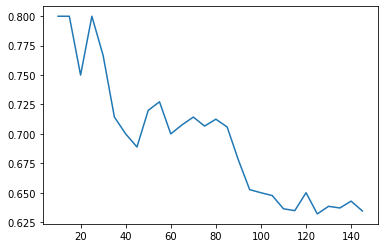

In [50]:
acc_test_size = []
for i in range(79010,79150,5):
    X_test = X[79000:i]
    y_test = y[79000:i]

    predictions = model.predict(X_test)
    acc_test_size.append(accuracy_score(predictions,y_test))

plt.plot((np.asarray(range(0,len(acc_test_size)))*5)+10,acc_test_size)

In fact we see that short-term prediction performs a lot better than long-term prediction, which might be surprising since time dependency is used by the model only implicitly (recent matches are not weighted stronger than previous ones), in contrast to time-series e.g. But one reason for this decrease in accuracy over time is the fact that players are included in the test set that were not seen in training, and therefore cannot be classified correctly by the model. We therefore decided to construct additional models that capture short-term information, in order to include them into our workflow.

There is a built-in method in xgboost that enables us to get pseudo-probabilities for all classes (players) and for all observations. In other words, for each observation and for each class we get the model's degree of belief that the observation's outcome is the corresponding class. This is what the following line of code does.

In [11]:
probas = model.predict_proba(X_test)
probas

array([[1.17657055e-05, 6.10477036e-06, 5.06009656e-06, ...,
        3.09780967e-06, 4.45846399e-06, 2.64357868e-06],
       [9.77836680e-06, 5.69931290e-05, 3.43374109e-06, ...,
        1.33057702e-05, 3.55924712e-05, 3.63917047e-06],
       [1.23094622e-04, 4.69773022e-06, 4.41537395e-06, ...,
        8.54459904e-06, 3.55166458e-06, 5.24266170e-06],
       ...,
       [3.25598121e-05, 6.53073439e-05, 1.93921496e-05, ...,
        2.36343330e-05, 1.07310720e-04, 1.21474886e-05],
       [6.43983149e-05, 1.31464179e-03, 3.18824896e-05, ...,
        3.40843690e-05, 3.02871777e-04, 4.39720352e-05],
       [1.98481230e-05, 4.59344359e-04, 1.33352514e-05, ...,
        1.44497199e-05, 7.10475797e-06, 2.46057189e-05]], dtype=float32)

For each observation in the testset we extract the maximum pseudo-probability and save it in an array called 'max_proba'. The following dataframe contains for each element in the testset the player's names, as well as the actual outcome, the predicted outcome and the maximum pseudo-probability.

In [43]:
testframe.head()

,Player_1,Player_2,y_test,y_pred,max_proba
0,David Goffin,Gael Monfils,David Goffin,Gael Monfils,0.593989
1,Pablo Carreno Busta,Marco Cecchinato,Marco Cecchinato,Pablo Carreno Busta,0.587652
2,Roberto Bautista Agut,Novak Djokovic,Novak Djokovic,Novak Djokovic,0.694759
3,Grigor Dimitrov,Fernando Verdasco,Fernando Verdasco,Fernando Verdasco,0.650181
4,Matteo Berrettini,Dominic Thiem,Dominic Thiem,Dominic Thiem,0.967960


In the following we see that matches that contain a player whose name was not seen during training are classified totally wrong. (The model predicts players that were not even part of the match.)

In [11]:
testframe[(testframe['y_pred']!=testframe['Player_1']) & (testframe['y_pred']!=testframe['Player_2'])].head(10)

,Player_1,Player_2,y_test,y_pred,max_proba
40,Mackenzie Mcdonald,Alex Bolt,Mackenzie Mcdonald,Dennis Novikov,0.060883
177,Cameron Norrie,Jay Clarke,Cameron Norrie,Ramkumar Ramanathan,0.106073
207,Peter Polansky,Dennis Novak,Dennis Novak,Dennis Novikov,0.098573
214,Stefanos Tsitsipas,Gregoire Barrere,Stefanos Tsitsipas,Ruben Bemelmans,0.031417
232,Taylor Harry Fritz,Lorenzo Sonego,Taylor Harry Fritz,Dennis Novikov,0.177452
246,Alex De Minaur,Marco Cecchinato,Alex De Minaur,Dennis Novikov,0.189377
259,Nicolas Jarry,Mackenzie Mcdonald,Mackenzie Mcdonald,Dennis Novikov,0.181972
289,Stefanos Tsitsipas,Thomas Fabbiano,Stefanos Tsitsipas,Stefan Kozlov,0.090335
314,Radu Albot,Pedro Sousa,Pedro Sousa,Pavol Cervenak,0.081600
319,Jaume Munar,Casper Ruud,Casper Ruud,Blaz Rola,0.081963


But we also observe that the model is very unconfident about these classifications, and so they can easily be filtered out by restricting to matches whose 'max_proba' values exceed a certain threshold. (Note that this is always possible in practice.)

Also have a look at the third row of the previous frame, where 'Dennis Novak' was incorrectly classified as 'Dennis Novikov'. (By the way this is not due to typo, both are professional tennis players!)

The previous observations suggest that restricting ourselves to observations with higher pseudo-probability values leads to higher accuracy scores for classification, which can be seen in the following, where the x-axis represents the minimum 'max_proba' value we restrict on and the y-axis represents the corresponing accuracy score. This is done on the first 100 test observations.

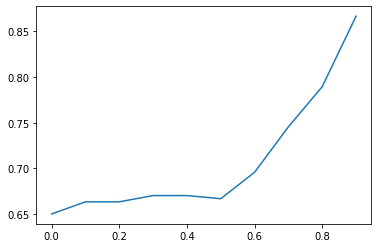

In [64]:
acc = []
for i in np.arange(0,1,.1):
    a = testframe.head(100).loc[testframe['max_proba']>=i]
    acc.append(accuracy_score(a['y_test'],a['y_pred']))
    
plt.plot(np.arange(0,1,.1),acc)

Now the idea is to construct a measure of short-time performance of a player which is used as a weight for 'max_proba'. (The likelihood to win should be higher for a player who played a superior season than for one who performed poorly over the last matches e.g.) For this purpose we used a bayesian approach, in order to get a possibly high degree in flexibility and to be able to easily incorporate additional information about a player, if available.

### Bayesian model

Performance in tennis is largely determined by the rate of points that were won (relative to the opponent's performance), and the rate of unforced errors. In our dataset, information about the former is given by the percentage of second services that led to winning points, and the latter is encoded by the number of double faults. (Note that we also have access to the percentage of first services that led to winners, but we could not find any significant correlation of this magnitude and the likelihood to win a match.)
The following two plots show the historical distributions of second service winner percentage ('2ndWon') and of the logarithm of second service winner percentage ('log2ndWon'), both for Novak Djokovic.

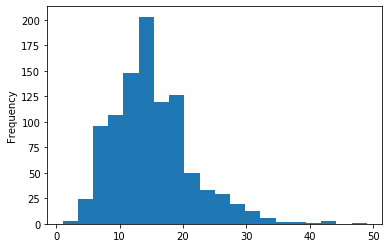

In [5]:
djokovic_atp['2ndWon'].plot.hist(bins=20)

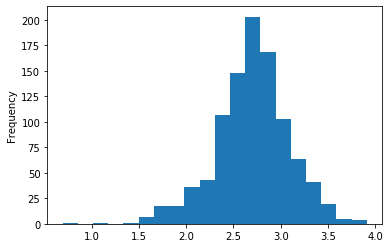

In [6]:
djokovic_atp['log2ndWon'].plot.hist(bins=20)

We observe that the 'log2ndWon' distribution looks normally distributed and normality tests confirm significance of this assumption, in general. We therefore model 'log2ndWon' as a normal distribution.

The next plot shows Djokovic' distribution of double faults ('df') which seems to follow a Poisson distribution.

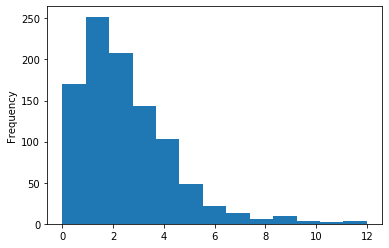

In [8]:
djokovic_atp['df'].plot.hist(bins=13)

Similar arguments as before show that this generalizes for players and we therefore model 'df' as Poisson.

The remaining procedure is as follows: for each match in the test set we use our baseline model to predict the winner. We then model the short-term distributions of 'log2ndWon' and 'df' for the predicted winner (by restricting only to the last few observations) and compare these with their respective overall distributions. This comparison measure is then used as a weight for the maximum probability ('max_proba') of our baseline model. 

We used PyMC3 for our implementation and the following  code implements our vanilla bayesian models.

In [ ]:
import pymc3 as pm

# model for 'log2ndWon'
with pm.Model() as model:
    
    mu = pm.Uniform('mu',0,10)
    sigma = pm.Uniform('sigma',0,20)

    likelihood = pm.Normal('likelihood',mu,sigma,observed=obs)

    trace = pm.sample(10000)
    
    
# model for 'df'
with pm.Model() as model:
    
    lamb = pm.Uniform('lamb',0,20)

    likelihood = pm.Poisson('likelihood',lamb,observed=obs)

    trace = pm.sample(10000)

Note that we used uniform priors for our parameters in both models, in order to get unbiased short-term distributions. But varying the prior enables one to easily incorporate additional information into the model, if accessible.

The observations that are used for inference are encoded in an array called 'obs', and 'trace' contains samples of the corresponding posterior distribution.

In our experiments we model short-term performance with respect to the last ten games, but this is a hyperparameter that may be tuned. Long-term performance is measured with respect to all past matches of the respective player. For each match we compute the respective means of the winner's short- and long-term distributions and encode them into our testframe as variables called 'short_df_mean' and 'df_mean' in the case of 'df', and similarly for '2ndWon'. (Remember that for the latter we need to exponentiate before taking the mean, since we modeled the variable's logarithm!)

In [21]:
testframe.head()

,Player_1,Player_2,y_test,y_pred,max_proba,short_df_mean,df_mean,short_2ndWon_mean,2ndWon_mean
0,David Goffin,Gael Monfils,David Goffin,Gael Monfils,0.593989,4.206297,3.506494,10.836340,15.092352
1,Pablo Carreno Busta,Marco Cecchinato,Marco Cecchinato,Pablo Carreno Busta,0.587652,1.794153,1.889680,14.595709,14.754448
2,Roberto Bautista Agut,Novak Djokovic,Novak Djokovic,Novak Djokovic,0.694759,2.301889,2.248731,11.546485,15.073096
3,Grigor Dimitrov,Fernando Verdasco,Fernando Verdasco,Fernando Verdasco,0.650181,4.305555,3.966960,10.712679,13.327093
4,Matteo Berrettini,Dominic Thiem,Dominic Thiem,Dominic Thiem,0.967960,4.408923,2.960674,16.539290,17.005618


We now use these performance measures as a weight for 'max_proba', as follows.

In [31]:
testframe['max_proba_weighted'] = testframe.apply(lambda x: (x['max_proba']**((x['short_df_mean']/x['df_mean'])**(.5)*(x['2ndWon_mean']/x['short_2ndWon_mean'])**(1))),axis=1)

Note that this weighting procedure is designed in a way that if short-term performance is higher (i.e. less double faults or higher rate of won points) than long-term performance, then the 'max_proba_weighted' value is greater than the original 'max_proba' value. In other words, we use the model's degree of belief that the winner is in fact the predicted player and we increase (decrease) it if he overperformed (underperformed) over the last few games. Moreover, we only gave half the weight to 'df' since the rate of won points appeared to be more meaningful for performance. As we exponentiate a value between zero and one, we ensure that our weighting procedure leads to a number between zero and one, as well.

The following shows accuracy scores of our baseline model for a varying number of observations, where the blue chart represents accuracy only of observations in the testset whose 'max_proba' value exceeds a threshold of 0.5 and the orange chart represents accuracy of observations whose 'max_proba_weighted' value exceeds this threshold.

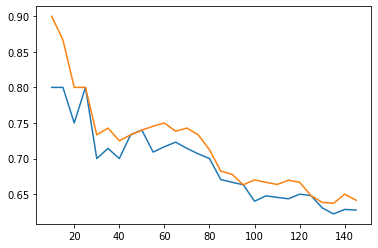

In [20]:
j = .5

df = testframe

arr_a = []
arr_b = []

df_a = df[df['max_proba']>j]
df_b = df[df['max_proba_weighted']>j]

for i in range(10,150,5):
    arr_a.append(accuracy_score(df_a.iloc[:i,:]['y_test'],df_a.iloc[:i,:]['y_pred']))
    arr_b.append(accuracy_score(df_b.iloc[:i,:]['y_test'],df_b.iloc[:i,:]['y_pred']))
    
plt.plot((np.asarray(range(0,len(arr_a)))*5)+10,arr_a)
plt.plot((np.asarray(range(0,len(arr_b)))*5)+10,arr_b)

Accuracy decreases for an increasing number of future predictions, which is something we have already noticed. But we additionally observe that the overall accuracy is significantly higher for samples whose weighted pseudo-probability value exceeds a certain threshold, than for samples whose original pseudo-probability exceeds this threshold. In other words, incorporating short-term weights into our workflow leads to a selection of matches on which our model performs significantly better. (Note that the reason for this improvement in accuracy is not restriction to a smaller subset of samples.)

## Discussion

In this project we presented a hybrid modeling approach to tennis outcome prediction. We decided to choose boosting trees as our baseline model, for performance reasons. However, the downside of xgboost is that it cannot be retrained, which is due to the learning algorithm itself since additional data may lead to very different structures of decision trees. It took us about eight hours to train our model on a single machine, which still should be feasible in practice. 

Something we did not discuss so far is the choice of weights in our pseudo-probability weighting procedure. Although weighting parameters of 0.5 and 1 performed best in our experiments, these are numbers that might be learned (e.g. by a meta-learning algorithm).

Also recall that we only made use of the means of posterior distributions that were inferred. One might additionally use the variance as a measure for stability of performance, and therefore as a measure of credibility of the corresponding shoirt-term performance. (The bayesian approach makes it easy to add this into the workflow via credible intervals e.g.)

As we have seen, short-term performance information is very predictive for tennis outcomes. This suggests that real-time data may lead to much better results, as it enables one to incorporate live performance measures that capture the current daily condition of a player.